# Pre-activation ResNet

- Paper: [2016.03.16] Identity Mappings in Deep Residual Networks
- https://arxiv.org/abs/1603.05027

### [Package load]

In [1]:
import torch 
print('pytorch version: {}'.format(torch.__version__))

import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import glob
import os
import matplotlib.pyplot as plt
import numpy as np
from tqdm.notebook import tqdm
%matplotlib inline

print('pytorch version: {}'.format(torch.__version__))
print('GPU 사용 가능 여부: {}'.format(torch.cuda.is_available()))
device = "cuda" if torch.cuda.is_available() else "cpu"   # GPU 사용 가능 여부에 따라 device 정보 저장

pytorch version: 2.2.2
pytorch version: 2.2.2
GPU 사용 가능 여부: False


### [Model: Preactivation ResNet 152]

참고: https://github.com/weiaicunzai/pytorch-cifar100/blob/master/models/preactresnet.py

- #### Bottleneck

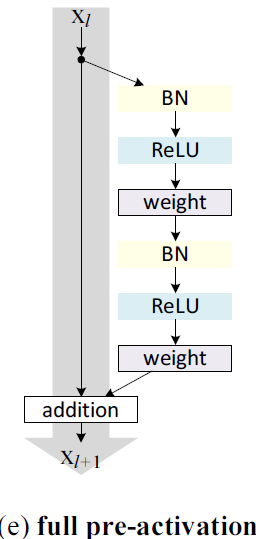

In [3]:
class BottleNeck(nn.Module):
    expansion = 4
    def __init__(self, in_channels, out_channels, stride, downsample=None):
        super().__init__()

        self.residual = nn.Sequential(
            nn.BatchNorm2d(in_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels, out_channels, 1, stride=stride),

            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, 3, padding=1),

            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels * BottleNeck.expansion, 1)
        )

        self.downsample = downsample

    def forward(self, x):
        short_cut = x
        residual = self.residual(x)
        if self.downsample is not None:
            short_cut = self.downsample(x)
        return residual + short_cut

- #### Pre activation ResNet

In [41]:
class PreActResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes=1000, init_weights=True):
        super().__init__()
        self.in_channels = 64

        self.conv1 = nn.Sequential(
            nn.Conv2d(3, 64, 3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU()
        )

        self.layer2 = self._make_layers(block, num_blocks[0], 64, 1)
        self.layer3 = self._make_layers(block, num_blocks[1], 128, 2)
        self.layer4 = self._make_layers(block, num_blocks[2], 256, 2)
        self.layer5 = self._make_layers(block, num_blocks[3], 512, 2)
        
        self.last_act = nn.Sequential(
            nn.BatchNorm2d(512 * BottleNeck.expansion),
            nn.ReLU(),
        )
        self.avg_pool = nn.AdaptiveAvgPool2d((1,1))
        
        self.linear = nn.Linear(512 * BottleNeck.expansion, num_classes)

        # weights Initialization
        if init_weights:
            self._initialize_weights()

    def _make_layers(self, block, block_num, out_channels, stride):
        downsample = None
        if stride != 1 or self.in_channels != out_channels * block.expansion:   
                            # inplanes = 64 != 64 * 4 (bottleneck의 expansion)
            downsample = nn.Sequential(
                nn.Conv2d(self.in_channels, out_channels * block.expansion, 1, stride=stride), #conv(in_channel, in_channel x expansion, 1)
                nn.BatchNorm2d(out_channels * block.expansion), #batchnrom2d(256)
            )
            # 원래 feature 수 맞추려고 쓰는데 여기서는 channel을 맞추는 용도로 사용함
        
        layers = []

        layers.append(block(self.in_channels, out_channels, stride, downsample))
            # stride 2인 경우 이 때 한 번 2가 들어감
        self.in_channels = out_channels * block.expansion

        for _ in range(1, block_num):
            # 위에서 한 번 append 했으니 block_num-1만큼 append를 함
            layers.append(block(self.in_channels, out_channels, 1))

        return nn.Sequential(*layers)

    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, 0, 0.01)
                nn.init.constant_(m.bias, 0)

    def forward(self, x):
        x = self.conv1(x)

        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.layer5(x)
        x = self.last_act(x)
        x = self.avg_pool(x)
        
        x = x.view(x.size(0), -1)
        x = self.linear(x)

        return x

In [42]:
preresnet152 = PreActResNet(BottleNeck, [3,8,36,3], 1000, True).to(device) 
# 1(conv1) + 9(layer1) + 24(layer2) +108(layer3) + 9(layer4) +1(fc)= preactivation ResNet152

In [43]:
preresnet152

PreActResNet(
  (conv1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (layer2): Sequential(
    (0): BottleNeck(
      (residual): Sequential(
        (0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (1): ReLU(inplace=True)
        (2): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1))
        (3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (4): ReLU(inplace=True)
        (5): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (6): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (7): ReLU(inplace=True)
        (8): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1))
      )
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1))
        (1): BatchNo

In [44]:
temp = torch.Tensor(np.random.randint(1, 255, size=(1, 3, 224, 224)))
preresnet152(temp).size()

torch.Size([1, 1000])

In [45]:
from torchsummary import summary
summary(preresnet152, (3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 224, 224]           1,792
       BatchNorm2d-2         [-1, 64, 224, 224]             128
              ReLU-3         [-1, 64, 224, 224]               0
       BatchNorm2d-4         [-1, 64, 224, 224]             128
              ReLU-5         [-1, 64, 224, 224]               0
            Conv2d-6         [-1, 64, 224, 224]           4,160
       BatchNorm2d-7         [-1, 64, 224, 224]             128
              ReLU-8         [-1, 64, 224, 224]               0
            Conv2d-9         [-1, 64, 224, 224]          36,928
      BatchNorm2d-10         [-1, 64, 224, 224]             128
             ReLU-11         [-1, 64, 224, 224]               0
           Conv2d-12        [-1, 256, 224, 224]          16,640
           Conv2d-13        [-1, 256, 224, 224]          16,640
      BatchNorm2d-14        [-1, 256, 2

In [47]:
from torchinfo import summary
summary(preresnet152, input_size=(1, 3, 224, 224), col_width=20, depth=200, row_settings=["depth", "var_names"], col_names=["input_size", "kernel_size", "output_size", "params_percent"])

Layer (type (var_name):depth-idx)             Input Shape          Kernel Shape         Output Shape         Param %
PreActResNet (PreActResNet)                   [1, 3, 224, 224]     --                   [1, 1000]                 --
├─Sequential (conv1): 1-1                     [1, 3, 224, 224]     --                   [1, 64, 224, 224]         --
│    └─Conv2d (0): 2-1                        [1, 3, 224, 224]     [3, 3]               [1, 64, 224, 224]      0.00%
│    └─BatchNorm2d (1): 2-2                   [1, 64, 224, 224]    --                   [1, 64, 224, 224]      0.00%
│    └─ReLU (2): 2-3                          [1, 64, 224, 224]    --                   [1, 64, 224, 224]         --
├─Sequential (layer2): 1-2                    [1, 64, 224, 224]    --                   [1, 256, 224, 224]        --
│    └─BottleNeck (0): 2-4                    [1, 64, 224, 224]    --                   [1, 256, 224, 224]        --
│    │    └─Sequential (residual): 3-1        [1, 64, 224, 224] 